# SEP 769: Cyber-Physical Systems Part II - Detect Al-Generated Text Dataset

## Library Dependency 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
import os
from dotenv import load_dotenv
load_dotenv() # Load environment variables from the .env file
# Define the directory where you want to save the model and tokenizer
model_name = "roberta-base"                  # Load Local model
save_directory = "./roberta_model"           # Trained Model and Tokenizer
result_directory = "./essay-detect-roberta"  # Trained Results from each step
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3070


## Load Data

In [3]:
# Load the dataset
file_path = 'Training_Essay_Data.csv'
dataset = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(dataset.head())
# Check the dataset information
print(dataset['generated'].value_counts())
dataset.info()

                                                text  generated
0  Car-free cities have become a subject of incre...          1
1  Car Free Cities  Car-free cities, a concept ga...          1
2    A Sustainable Urban Future  Car-free cities ...          1
3    Pioneering Sustainable Urban Living  In an e...          1
4    The Path to Sustainable Urban Living  In an ...          1
generated
0    17508
1    11637
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29145 entries, 0 to 29144
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       29145 non-null  object
 1   generated  29145 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 455.5+ KB


## Data Preprocessing

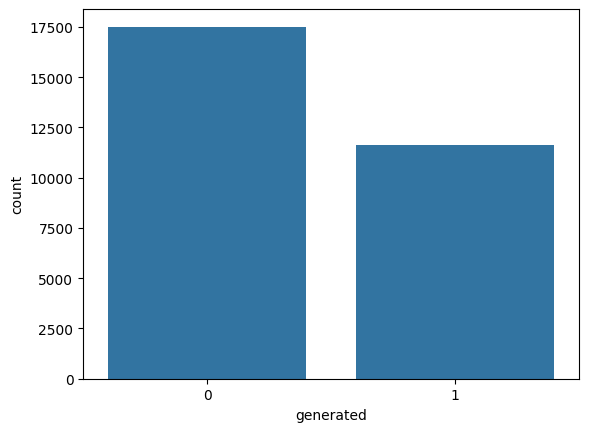

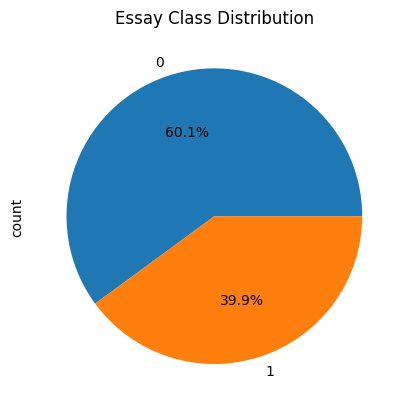

In [4]:
sns.countplot(x=dataset['generated'])
plt.show()

dataset['generated'].value_counts().plot(kind="pie",autopct="%.1f%%")
plt.title("Essay Class Distribution")
plt.show()

### Balance the dataset

In [5]:
# Balancing the dataset by oversampling the minority class
def balance_labels(df, label_column='generated'):
    # Get the counts of each label
    label_counts=df[label_column].value_counts()
    # Get the maximum count
    max_count=label_counts.max()
    # Create an empty DataFrame
    balanced_df=pd.DataFrame()
    
    # For each label, create a subset of the DataFrame with that label
    for label, count in label_counts.items():
        # If the count is equal to the maximum count, don't do anything
        label_subset = df[df[label_column]==label]
        # Create a subset of the label with replacement
        oversampled_subset= label_subset.sample(n=(max_count-count), replace=True, random_state=42)
        balanced_df = pd.concat([balanced_df, label_subset, oversampled_subset], ignore_index=True)
        
    return balanced_df

dataset = balance_labels(dataset)

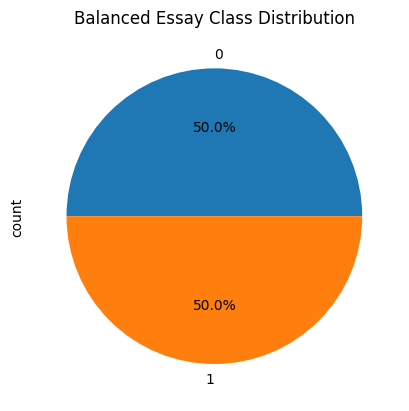

generated
0    17508
1    17508
Name: count, dtype: int64

In [6]:
dataset['generated'].value_counts().plot(kind="pie",autopct="%.1f%%")
plt.title("Balanced Essay Class Distribution")
plt.show()
# Check the dataset statistics
dataset['generated'].value_counts()

### Train Test Split

In [7]:
# Check for missing values
print(dataset.isnull().sum())

# Drop rows with missing values (if any)
dataset.dropna(inplace=True)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(dataset['text'], dataset['generated'], test_size=0.2, random_state=42)


text         0
generated    0
dtype: int64


### Data Distribution

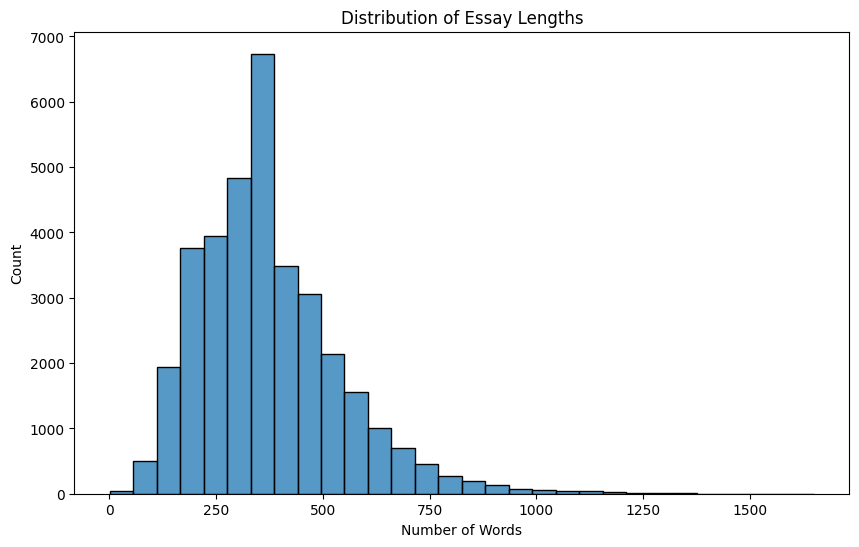

Ave Length:  371 words
Min Length:  1 words
Max Length:  1650 words


In [8]:
# Ploy the distribution of the essay lengths
plt.figure(figsize=(10, 6))
sns.histplot(dataset['text'].apply(lambda x: len(x.split())), bins=30)
plt.title('Distribution of Essay Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.show()

# Get average length of the essays
avg_length = dataset['text'].apply(lambda x: len(x.split())).mean()
# Get the min and max length of the essays
min_length = dataset['text'].apply(lambda x: len(x.split())).min()
max_length = dataset['text'].apply(lambda x: len(x.split())).max()
print("Ave Length: ", round(avg_length), "words")
print("Min Length: ", min_length, "words")
print("Max Length: ", max_length, "words")

## RoBERTa (Robustly Optimized BERT) model

In [9]:
# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Tokenize the text data
tokenizer = RobertaTokenizer.from_pretrained(model_name)

class EssayDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',  # Padding
            truncation=True,       # Truncation
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Define max sequence length
MAX_LEN = 256

# Create datasets
train_dataset = EssayDataset(X_train, y_train_encoded, tokenizer, max_len=MAX_LEN)
test_dataset = EssayDataset(X_test, y_test_encoded, tokenizer, max_len=MAX_LEN)

In [10]:
# Load the model
roberta_model = model_name                      # RoBERTa model
model = RobertaForSequenceClassification.from_pretrained(
    roberta_model,         # Use the 12-layer BERT model, with an uncased vocab.
    # device_map="auto",  # device_map moves model to the appropriate device (GPU or CPU) automatically
    num_labels=2,       # The number of output labels--2 for binary classification.
    )
# # Set the padding token to the end of the sequence
# tokenizer.pad_token = tokenizer.eos_token
# # Resize the token embeddings
# model.resize_token_embeddings(len(tokenizer))
model


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [11]:
# Define training arguments
training_args = TrainingArguments(
    output_dir=result_directory,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    # logging_dir='./logs',
    # logging_steps=10,
    evaluation_strategy='steps',
)

# Define the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda p: {'accuracy': accuracy_score(p.label_ids, p.predictions.argmax(-1))}
)


c:\Users\aiden\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
# Train the model
trainer.train()

  0%|          | 0/5253 [00:00<?, ?it/s]

{'loss': 0.1687, 'grad_norm': 21.95887565612793, 'learning_rate': 5e-05, 'epoch': 0.29}


  0%|          | 0/438 [00:00<?, ?it/s]

{'eval_loss': 0.016721419990062714, 'eval_accuracy': 0.9958595088520845, 'eval_runtime': 55.1849, 'eval_samples_per_second': 126.919, 'eval_steps_per_second': 7.937, 'epoch': 0.29}
{'loss': 0.0522, 'grad_norm': 0.0033454622607678175, 'learning_rate': 4.474016410687987e-05, 'epoch': 0.57}


  0%|          | 0/438 [00:00<?, ?it/s]

{'eval_loss': 0.09070789068937302, 'eval_accuracy': 0.9875785265562536, 'eval_runtime': 55.5922, 'eval_samples_per_second': 125.989, 'eval_steps_per_second': 7.879, 'epoch': 0.57}
{'loss': 0.0373, 'grad_norm': 0.01939048059284687, 'learning_rate': 3.9480328213759734e-05, 'epoch': 0.86}


  0%|          | 0/438 [00:00<?, ?it/s]

{'eval_loss': 0.04389408230781555, 'eval_accuracy': 0.9914334665905197, 'eval_runtime': 139.6294, 'eval_samples_per_second': 50.161, 'eval_steps_per_second': 3.137, 'epoch': 0.86}
{'loss': 0.0215, 'grad_norm': 0.0020709929522126913, 'learning_rate': 3.42204923206396e-05, 'epoch': 1.14}


  0%|          | 0/438 [00:00<?, ?it/s]

{'eval_loss': 0.009016248397529125, 'eval_accuracy': 0.9985722444317533, 'eval_runtime': 59.7362, 'eval_samples_per_second': 117.249, 'eval_steps_per_second': 7.332, 'epoch': 1.14}
{'loss': 0.0134, 'grad_norm': 191.36972045898438, 'learning_rate': 2.896065642751946e-05, 'epoch': 1.43}


  0%|          | 0/438 [00:00<?, ?it/s]

{'eval_loss': 0.03808911517262459, 'eval_accuracy': 0.9945745288406624, 'eval_runtime': 59.377, 'eval_samples_per_second': 117.958, 'eval_steps_per_second': 7.377, 'epoch': 1.43}
{'loss': 0.005, 'grad_norm': 0.002215166110545397, 'learning_rate': 2.370082053439933e-05, 'epoch': 1.71}


  0%|          | 0/438 [00:00<?, ?it/s]

{'eval_loss': 0.018487457185983658, 'eval_accuracy': 0.9975728155339806, 'eval_runtime': 57.6712, 'eval_samples_per_second': 121.447, 'eval_steps_per_second': 7.595, 'epoch': 1.71}
{'loss': 0.0082, 'grad_norm': 0.001983484486117959, 'learning_rate': 1.8440984641279193e-05, 'epoch': 2.0}


  0%|          | 0/438 [00:00<?, ?it/s]

{'eval_loss': 0.028110932558774948, 'eval_accuracy': 0.9958595088520845, 'eval_runtime': 57.829, 'eval_samples_per_second': 121.116, 'eval_steps_per_second': 7.574, 'epoch': 2.0}
{'loss': 0.0025, 'grad_norm': 0.0009093608241528273, 'learning_rate': 1.3181148748159059e-05, 'epoch': 2.28}


  0%|          | 0/438 [00:00<?, ?it/s]

{'eval_loss': 0.010249525308609009, 'eval_accuracy': 0.9987150199885779, 'eval_runtime': 59.7032, 'eval_samples_per_second': 117.314, 'eval_steps_per_second': 7.336, 'epoch': 2.28}
{'loss': 0.0009, 'grad_norm': 0.0006790023180656135, 'learning_rate': 7.921312855038922e-06, 'epoch': 2.57}


  0%|          | 0/438 [00:00<?, ?it/s]

{'eval_loss': 0.013337858952581882, 'eval_accuracy': 0.9981439177612793, 'eval_runtime': 59.7069, 'eval_samples_per_second': 117.306, 'eval_steps_per_second': 7.336, 'epoch': 2.57}
{'loss': 0.0017, 'grad_norm': 0.0010208949679508805, 'learning_rate': 2.661476961918788e-06, 'epoch': 2.86}


  0%|          | 0/438 [00:00<?, ?it/s]

{'eval_loss': 0.01730266585946083, 'eval_accuracy': 0.9975728155339806, 'eval_runtime': 58.8175, 'eval_samples_per_second': 119.08, 'eval_steps_per_second': 7.447, 'epoch': 2.86}
{'train_runtime': 2680.8459, 'train_samples_per_second': 31.347, 'train_steps_per_second': 1.959, 'train_loss': 0.029646038257369944, 'epoch': 3.0}


TrainOutput(global_step=5253, training_loss=0.029646038257369944, metrics={'train_runtime': 2680.8459, 'train_samples_per_second': 31.347, 'train_steps_per_second': 1.959, 'total_flos': 1.105540032411648e+16, 'train_loss': 0.029646038257369944, 'epoch': 3.0})

In [13]:
# Evaluate the model
trainer.evaluate()

  0%|          | 0/438 [00:00<?, ?it/s]

{'eval_loss': 0.017475241795182228,
 'eval_accuracy': 0.9975728155339806,
 'eval_runtime': 59.4031,
 'eval_samples_per_second': 117.906,
 'eval_steps_per_second': 7.373,
 'epoch': 3.0}

### Exporting the Model

In [14]:
# Save the model
model.save_pretrained(save_directory)

# Save the tokenizer
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved to {save_directory}")

Model and tokenizer saved to ./roberta_model


## Load Local Model

In [15]:
# Load the model and tokenizer
model = RobertaForSequenceClassification.from_pretrained(save_directory)
tokenizer = RobertaTokenizer.from_pretrained(save_directory)
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

## Prediction Test

In [16]:
# Predict the class of a given text
def predict(input_text):
    # Tokenize the input text
    encoding = tokenizer.encode_plus(
        input_text,
        add_special_tokens=True,
        max_length=MAX_LEN,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    
    # Move the tensors to the appropriate device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Ensure the model is in evaluation mode
    model.eval()
    # Make the prediction
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    
    # Get the predicted class
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()
    
    # Interpret the prediction
    if prediction == 1:
        result = "The content is written by AI."
    else:
        result = "The content is written by a human."
    
    return result



In [17]:
# Example usage
user_input = "I think using technology to scan someones facial expressions would be a great way for people to interact more with the internet and social media . Even though, many people will disaprove of it saying how it evades there child's privacy. Even though this may happen, there could be some good side effects from this new technology. One good side affect was pointed out by Dr. Huang, 'A classroom computer could recognize when a student is becoming confused or bored,'Dr. Huang predicts. 'Then it could modify the lesson , like an effective human instructor.' Dr. Huang also noted how most human communication is nonverbal, including emotional communication. He then goe's to say how these new computers need to learn how to pick up these emotions and understand them, too. I myself feel that by useing this technology we will be able to help students study more, and concentrate more on there homwork assighnments sence they'll be more engaged in the subject because it peaks there interest. From this I feel like the new technology would be varry valuable not just to students but to teachers as well giveing them the opertunity to get to know the students better and to get to know what there students are interested in wheather it's sports or school work."
result = predict(user_input)
print(result)

The content is written by a human.


## Upload Model to Huggingface Account

In [18]:
from huggingface_hub import login
# Retrieve the Hugging Face token from the environment variables
huggingface_token = os.getenv("HUGGINGFACE_TOKEN")
# Log in to the Hugging Face model hub
login(token=huggingface_token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to C:\Users\aiden\.cache\huggingface\token
Login successful


In [19]:
# Push the model and tokenizer to the Hugging Face model hub
trainer.push_to_hub()
# model.push_to_hub("essay-detect-roberta")
# tokenizer.push_to_hub("essay-detect-roberta")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/aidenliw/results/commit/5dc158b34afe24e773383bc905c58f5313fc44b1', commit_message='essay-detect-roberta', commit_description='', oid='5dc158b34afe24e773383bc905c58f5313fc44b1', pr_url=None, pr_revision=None, pr_num=None)